<a href="https://colab.research.google.com/github/Sunkist2lee/EEE4178/blob/main/Project3_GRU_Train_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fashion MNIST Dataset Classification by GRU  

**1**. Define Hyper-parameters and device configuration 

In [ ]:
import torch

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
sequence_length = 28
input_size = 28     # input data의 차원
hidden_size = 128   # hidden state의 차원
num_layers = 2     # RNN의 은닉층 레이어 개수
num_classes = 10
batch_size = 100
num_epochs = 10
learning_rate = 0.001

In [ ]:
import torchvision
import torchvision.transforms as transforms

In [ ]:
# Load fashion-MNIST dataset

train_set = torchvision.datasets.FashionMNIST(root='./datasets',
                                        train=True,
                                        transform=transforms.ToTensor(),
                                        download=True)
 
test_data = torchvision.datasets.FashionMNIST(root='./datasets',
                                        train=False,
                                        transform=transforms.ToTensor(),
                                        download=True)

# split data stage
# split training data to training and validation data
train_data, val_data = torch.utils.data.random_split(train_set, [50000, 10000])

2. Define Dataloader

In [ ]:
# Data Loader
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_data,
                                        batch_size =batch_size,
                                        shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=batch_size,
                                          shuffle=False)

In [ ]:
# Fashion MNIST DATA CLASSES 정의
CLASSES = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

3. Check Data Sample Shape and Image

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

In [ ]:
def image_show(tensor_image):
  image = tensor_image.reshape(tensor_image.size()[1], tensor_image.size()[2])    # width x height
  imshow(image, cmap='gray')

images, labels = next(iter(train_loader))
image1, label1 = images[0], labels[0]

In [ ]:
print(train_data[0][0].shape)
print(train_data[0][-1])

torch.Size([1, 28, 28])
3


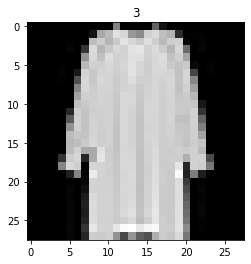

In [ ]:
plt.imshow(train_data[0][0].reshape(28,28),cmap='gray')
plt.title(train_data[0][-1])
plt.show()

4. Define Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(GRU, self).__init__()
        #save variables to use in other functions
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        #define GRU layer
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        #self.dropout = nn.Dropout(drop_percent)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

         # Forward prop
         out, _ = self.gru(x, h0)
         out = self.fc(out[:,-1,:])
         
         return out


model = GRU(input_size, hidden_size, num_layers, num_classes).to(device)

5. Set Loss Function & Optomizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

6. Train & Validation

6.1. Train Function

In [ ]:
def train(model, train_loader, optimizer, criterion):
  epoch_loss, acc = 0, 0
  model.train()
  
  for i, (image, label) in enumerate(train_loader):
    image = image.reshape(-1, sequence_length, input_size).to(device)
    label = label.to(device)

    # Forward
    output = model(image)
    loss = criterion(output, label)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

  return epoch_loss/(i+1)

6.2. Validation Function

In [ ]:
def evaluate(model, data_loader, criterion):
  epoch_loss, acc = 0, 0
  model.eval()

  with torch.no_grad():
    for (image, label) in data_loader:
      image = image.reshape(-1, sequence_length, input_size).to(device)
      label = label.to(device)

      output = model(image)
      loss = criterion(output, label)

      epoch_loss += loss.item()

  return epoch_loss/len(data_loader)

6.3. Train

In [ ]:
#### GRU ####
#### Train ####
loss_history = []
val_loss_history = []

print("____GRU____")
best_valid_loss = float('inf')
best_epoch = 0
for epoch in range(num_epochs):
  train_loss = train(model, train_loader, optimizer, criterion)
  valid_loss = evaluate(model, val_loader, criterion)
  loss_history.append(train_loss)
  val_loss_history.append(valid_loss)

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    best_epoch = epoch

  if epoch+1 == num_epochs:
    torch.save(model.state_dict(), 'gru_20161830.pth')
  else:
    torch.save(model.state_dict(), 'GRU-{:02d}_epochs.pth'.format(epoch+1))

  print("Epoch[{}/{}], Train Loss:{:.4f}, Valid Loss:{:.4f}".format(epoch+1, num_epochs, train_loss, valid_loss))

____GRU____
Epoch[1/10], Train Loss:0.7506, Valid Loss:0.4925
Epoch[2/10], Train Loss:0.4482, Valid Loss:0.3992
Epoch[3/10], Train Loss:0.3829, Valid Loss:0.3577
Epoch[4/10], Train Loss:0.3502, Valid Loss:0.3327
Epoch[5/10], Train Loss:0.3277, Valid Loss:0.3148
Epoch[6/10], Train Loss:0.3047, Valid Loss:0.3142
Epoch[7/10], Train Loss:0.2879, Valid Loss:0.2836
Epoch[8/10], Train Loss:0.2729, Valid Loss:0.2789
Epoch[9/10], Train Loss:0.2596, Valid Loss:0.2696
Epoch[10/10], Train Loss:0.2460, Valid Loss:0.2768


- Learning Curve (Validation Loss vs Epochs)

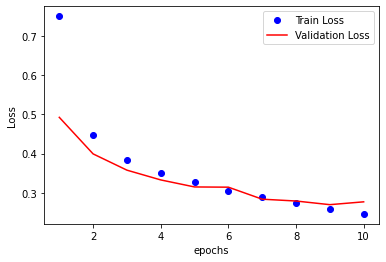

In [ ]:
plt.plot(range(1,len(loss_history)+1), loss_history, 'bo', label = 'Train Loss') 
plt.plot(range(1,len(val_loss_history)+1), val_loss_history, 'r-', label = 'Validation Loss') 

plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

7. Test Accuracy

In [ ]:
####### TEST ########
with torch.no_grad():
  correct = 0

  for image, label in test_loader:
    image = image.reshape(-1, sequence_length, input_size).to(device)
    label = label.to(device)
    output = model(image)
    _, pred = torch.max(output.data, 1)
    correct += (pred == label).sum().item()

  print('Test Accuracy of GRU model on the {} test images: {}%'.format(len(test_data), 100 * correct / len(test_data)))

Test Accuracy of GRU model on the 10000 test images: 89.14%
